In [11]:
import os, sys, re, gc, glob

# set working dir
WORKING_DIR = re.sub('jdi-qasp-ml.*$','',os.path.normpath(os.getcwd())) + 'jdi-qasp-ml'
os.chdir(WORKING_DIR)

import torch
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm, trange
from sklearn.metrics import confusion_matrix
import json

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

from tqdm.auto import tqdm, trange
from utils import JDNDataset, JDIModel, get_grey_image, assign_labels, logger, maximize_window, DatasetBuilder, load_gray_image
from time import sleep
from flask import jsonify

import datetime as dt
import requests

START_DT = dt.datetime.now()

In [2]:
SITE_URL = 'https://cnews.ru'

SAVE_SCREEN = True
WAIT_TIME_SECONDS = 7
HEADLESS = True #False

PREDICT_URL = 'http://localhost:5000/predict'
DATASET_NAME = 'cnews'


### getting json

2021-06-20 00:03:20,342 -INFO - dataset_builder:dataset_builder.py:77 - Dataset name: cnews
2021-06-20 00:03:20,343 -INFO - dataset_builder:dataset_builder.py:86 - Create directories to save the dataset
2021-06-20 00:03:20,345 -INFO - dataset_builder:dataset_builder.py:123 - Creating driver
2021-06-20 00:03:21,445 -INFO - dataset_builder:dataset_builder.py:131 - Chrome web driver is created
2021-06-20 00:03:21,564 -INFO - <ipython-input-3-3bebd7c6e53b>:<ipython-input-3-3bebd7c6e53b>:10 - getting url: https://cnews.ru
2021-06-20 00:03:25,817 -INFO - common:common.py:75 - Window maximized
2021-06-20 00:03:25,817 -INFO - dataset_builder:dataset_builder.py:134 - save scrinshot: dataset/images/cnews.png
2021-06-20 00:03:27,265 -INFO - dataset_builder:dataset_builder.py:178 - Collect features using JS script
2021-06-20 00:03:28,933 -INFO - dataset_builder:dataset_builder.py:186 - Save html to dataset/html/cnews.html
2021-06-20 00:03:28,960 -INFO - dataset_builder:dataset_builder.py:196 - Sav

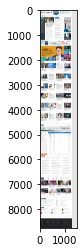

In [3]:
class DSBuilder(DatasetBuilder):
    def setUp(self, driver):
        """
            This method may be overwitten if you need to login to the site
            and navigate to a specific url,
            otherwise it just returns 
        """
        
        driver.set_window_size(width=1500, height=7900)
        logger.info(f'getting url: {self.url}')
        self.driver.get(self.url)
        sleep(3.0)
        maximize_window(driver=driver, extend_pix=0)
        
with DSBuilder(url=SITE_URL, dataset_name=DATASET_NAME, headless=True) as builder:
    plt.imshow(plt.imread(f'dataset/images/{DATASET_NAME}.png'))
    login_df = builder.dataset
    login_json = builder.dataset_json

  

In [4]:
PREDICT_URL

'http://localhost:5000/predict'

### Predict: sending json to backend and getting predictions

In [5]:
%%time

response = requests.post(
    PREDICT_URL, data=json.dumps(login_json)
)

if response.status_code == 200:
    display(json.loads(response.text))
else:
    raise Exception(response.text)

[{'element_id': '4818352001366072705826879375',
  'x': 20.0,
  'y': 1440.828125,
  'width': 927.0,
  'height': 449.0,
  'predicted_label': 'link',
  'predicted_probability': 0.9423238039,
  'sort_key': 416223.0},
 {'element_id': '6013530807366072707145295311',
  'x': 0.0,
  'y': 0.0,
  'width': 1280.0,
  'height': 200.0,
  'predicted_label': 'link',
  'predicted_probability': 0.9994803071,
  'sort_key': 256000.0},
 {'element_id': '8030328352366072709886938623',
  'x': 20.0,
  'y': 1220.828125,
  'width': 1240.0,
  'height': 200.0,
  'predicted_label': 'link',
  'predicted_probability': 0.9994803071,
  'sort_key': 248000.0},
 {'element_id': '1702793376366072717868208970',
  'x': 20.0,
  'y': 4669.953125,
  'width': 1240.0,
  'height': 200.0,
  'predicted_label': 'link',
  'predicted_probability': 0.9999932051,
  'sort_key': 248000.0},
 {'element_id': '4204766459366072704650841963',
  'x': 959.0,
  'y': 290.0,
  'width': 300.0,
  'height': 600.0,
  'predicted_label': 'link',
  'predicted

Wall time: 4.95 s


In [6]:
response

<Response [200]>

In [7]:
print('Elapsed time:', dt.datetime.now() - START_DT)

Elapsed time: 0:00:14.750510


In [10]:
predictions_df = pd.DataFrame(json.loads(response.text))


,element_id,x,y,width,height,predicted_label,predicted_probability,sort_key
0,4818352001366072705826879375,20.00000,1440.828125,927.0,449.0,link,0.942324,416223.0
1,6013530807366072707145295311,0.00000,0.000000,1280.0,200.0,link,0.999480,256000.0
2,8030328352366072709886938623,20.00000,1220.828125,1240.0,200.0,link,0.999480,248000.0
3,1702793376366072717868208970,20.00000,4669.953125,1240.0,200.0,link,0.999993,248000.0
4,4204766459366072704650841963,959.00000,290.000000,300.0,600.0,link,0.999993,180000.0
...,...,...,...,...,...,...,...,...
303,0081588535366072717244816852,36.00000,5081.953125,13.0,13.0,radiobutton,0.999999,169.0
304,1032026114366072717586782450,191.62500,5081.953125,13.0,13.0,radiobutton,0.999999,169.0
305,5803363583366072710699220066,36.00000,5113.953125,13.0,13.0,radiobutton,0.999999,169.0
306,6783886085366072711788253937,96.96875,5113.953125,13.0,13.0,radiobutton,0.999999,169.0


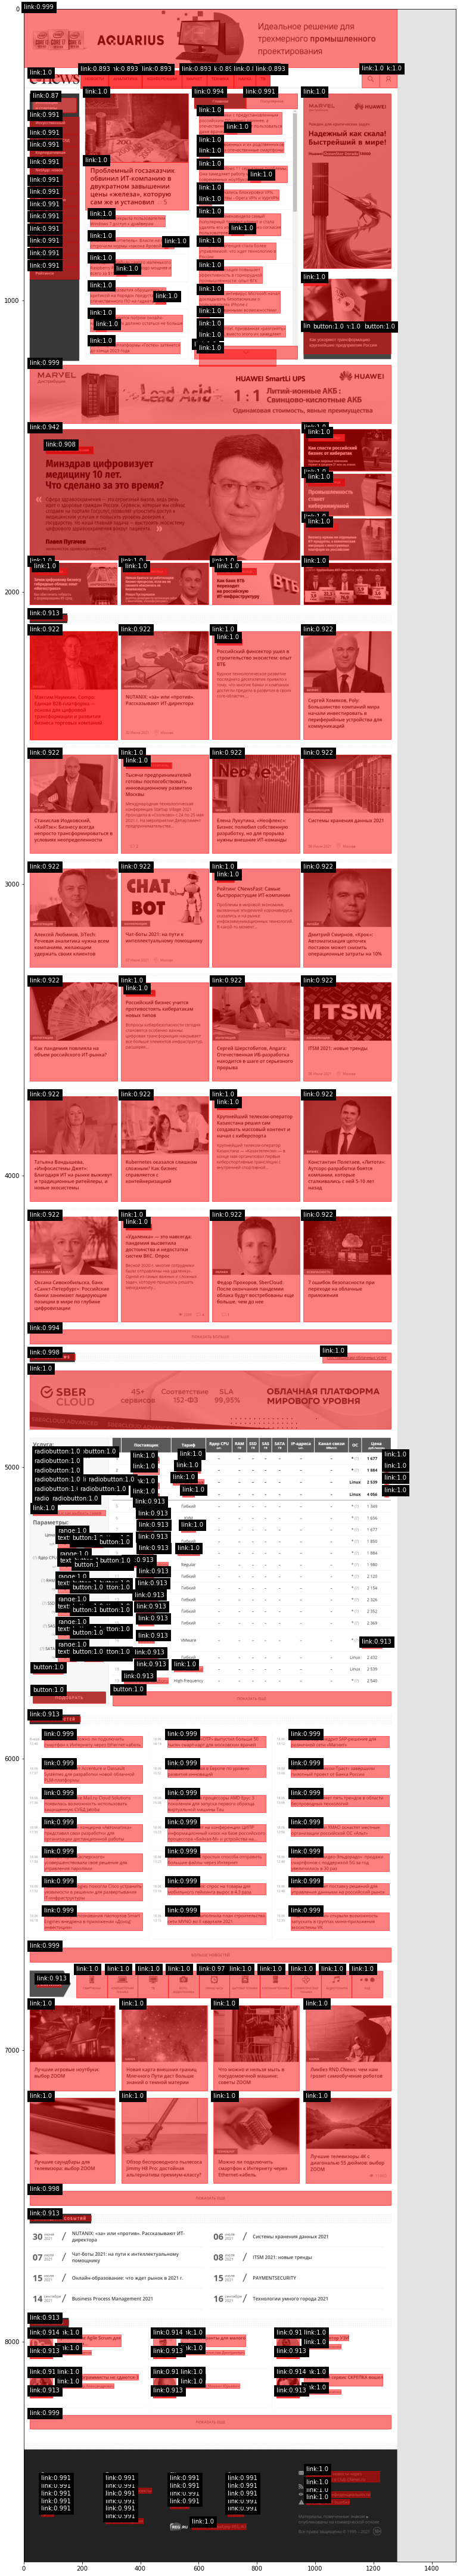

In [21]:
img = load_gray_image(f'dataset/images/{DATASET_NAME}.png')
plt.figure(figsize=(13,300))
plt.imshow(img, cmap='gray')

axes = plt.gca()

for _, r in predictions_df.iterrows():
    patch = Rectangle((r.x, r.y), r.width, r.height, alpha=.5, color='red')
    axes.add_patch(patch)
    
    axes.text(r.x, r.y, r.predicted_label + ':' +str(round(r.predicted_probability, 3)), backgroundcolor='black', color='white')
    